# Exploratory Analysis: HI-Small_Trans Dataset

This notebook explores transaction patterns, potential laundering indicators, and feature distributions to inform model development.

## 1. Imports and Setup
Import core libraries for data manipulation and visualisation. Seaborn is used for styling plots.

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs\plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_transaction_data
from src.report_utils import get_eda_summary
from src.report_utils import summarise_features

import tabulate
import json

pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="whitegrid")



## 2. Load and Inspect the Data
Load the transaction dataset using a custom loader function and preview its structure to understand the available features.

In [2]:
df = load_transaction_data("../data/raw/HI-Small_Trans.csv.gz", verbose=False)

 # Convert laundering flag (target feature) to categorical and map for easier reading in visualisations
df['is_laundering'] = df['is_laundering'].map({0: 'Not laundering', 1: 'Laundering'}).astype('category')

df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,Not laundering
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,Not laundering
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,Not laundering
3,2022-09-01 00:02:00,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,Not laundering
4,2022-09-01 00:06:00,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,Not laundering


In [9]:
df.shape

(5078345, 11)

In [5]:
shape_summary = {
    "rows": df.shape[0],
    "columns": df.shape[1]
}

os.makedirs("outputs", exist_ok=True)

with open(os.path.join(OUTPUT_DIR, "shape_summary.json"), "w") as f:
    json.dump(shape_summary, f, indent=2)

## 3. Dataset Overview
Examine the dataset’s shape, data types and missing values to assess data quality and identify preprocessing needs.

In [6]:
summary_df = summarise_features(df)
print(summary_df.to_markdown(index=False))

| Feature            | Data Type   |   Unique Values |   Missing Values |
|:-------------------|:------------|----------------:|-----------------:|
| amount_paid        | Decimal     |          923873 |                0 |
| amount_received    | Decimal     |          915161 |                0 |
| account            | Category    |          496995 |                0 |
| account.1          | Category    |          420636 |                0 |
| from_bank          | Category    |           30470 |                0 |
| to_bank            | Category    |           15811 |                0 |
| timestamp          | Date-Time   |           15018 |                0 |
| receiving_currency | Category    |              15 |                0 |
| payment_currency   | Category    |              15 |                0 |
| payment_format     | Category    |               7 |                0 |
| is_laundering      | Category    |               2 |                0 |


In [7]:
summary_df.to_csv(os.path.join(OUTPUT_DIR, "feature_summary.csv"), index=False)

In [4]:
df.describe().map(lambda x: f"{int(round(x))}")

,amount_received,amount_paid
count,5078345,5078345
mean,5988726,4509273
std,1037183109,869772831
min,0,0
25%,183,184
50%,1411,1415
75%,12346,12298
max,1046302363293,1046302363293


In [10]:
numeric_summary = df[["amount_paid", "amount_received"]].describe().map(lambda x: f"{int(round(x))}")
numeric_summary.to_csv(os.path.join(OUTPUT_DIR, "numeric_summary.csv"))

## 4. Target Variable Distribution
Explore the distribution of the `is_laundering` label to understand class balance and potential modeling challenges.

In [23]:
laundering_counts = df['is_laundering'].value_counts(normalize=True) * 100

print(f"Percent not laundering: {laundering_counts.get('Not laundering', 0):.4f}%")
print(f"Percent laundering: {laundering_counts.get('Laundering', 0):.4f}%")

Percent not laundering: 99.8981%
Percent laundering: 0.1019%


In [34]:
df["is_laundering"] = df["is_laundering"].astype(str).replace({
    "Not laundering": 0,
    "Laundering": 1
}).astype(int)

target_counts = df["is_laundering"].value_counts().to_dict()
total = int(df.shape[0])
flagged = int(target_counts.get(1, 0))
not_flagged = int(target_counts.get(0, 0))

imbalance_info = {
    "total": total,
    "flagged": flagged,
    "not_flagged": not_flagged,
    "percent_flagged": round(flagged / total * 100, 4),
    "percent_not_flagged": round(not_flagged / total * 100, 4)
}

with open(os.path.join(OUTPUT_DIR, "imbalance_summary.json"), "w") as f:
    json.dump(imbalance_info, f, indent=2)


In [37]:
print("Target counts:", target_counts)
print("Total:", total)
print("Flagged:", flagged)
print("Not flagged:", not_flagged)

Target counts: {0: 5073168, 1: 5177}
Total: 5078345
Flagged: 5177
Not flagged: 5073168


## 5. Feature Exploration
Analyse key features such as transaction amounts, currencies, banks and payment formats to uncover patterns and anomalies.

In [38]:
df.describe()

,timestamp,amount_received,amount_paid,is_laundering
count,5078345,5078345.00,5078345.00,5078345.00
mean,2022-09-05 07:16:08.194274816,5988726.07,4509273.37,0.00
min,2022-09-01 00:00:00,0.00,0.00,0.00
25%,2022-09-02 04:32:00,183.37,184.48,0.00
50%,2022-09-05 12:16:00,1411.01,1414.54,0.00
75%,2022-09-08 03:13:00,12346.27,12297.84,0.00
max,2022-09-18 16:18:00,1046302363293.48,1046302363293.48,1.00
std,NaN,1037183108.89,869772830.92,0.03


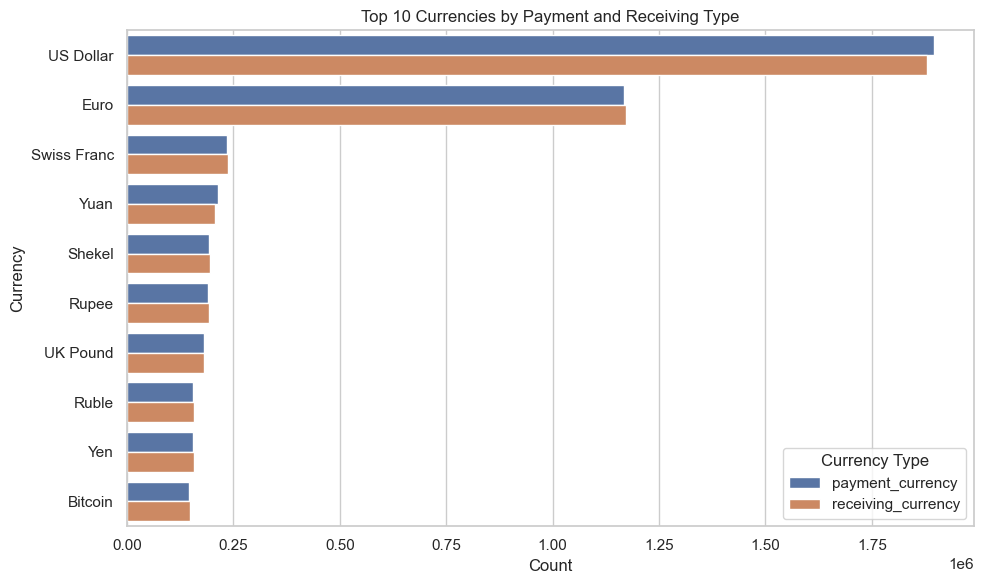

In [18]:
# Melt the currency columns into long format
currency_long = pd.melt(
    df,
    value_vars=['payment_currency', 'receiving_currency'],
    var_name='currency_type',
    value_name='currency'
)

# Get top 10 currencies overall
top_currencies = currency_long['currency'].value_counts().index[:10]

# Filter to top currencies only
currency_long = currency_long[currency_long['currency'].isin(top_currencies)]

OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs("outputs/plots", exist_ok=True)
plt.figure(figsize=(10, 6))

sns.countplot(
    data=currency_long,
    y='currency',
    hue='currency_type',
    order=top_currencies
)

plt.title("Top 10 Currencies by Payment and Receiving Type")
plt.xlabel("Count")
plt.ylabel("Currency")
plt.legend(title="Currency Type")
plt.tight_layout()

# Save to file

plt.savefig(os.path.join(OUTPUT_DIR, "top_10_currencies_countplot.png"), dpi=300)

# Optional: also show in notebook
plt.show()

In [17]:

# Total number of transactions
total_rows = len(df)

# Top 10 from_bank
top_from = (
    df['from_bank']
    .value_counts()
    .head(10)
    .rename_axis('from_bank')
    .reset_index(name='count')
)
top_from['percent'] = (top_from['count'] / total_rows * 100).round(2)

# Top 10 to_bank
top_to = (
    df['to_bank']
    .value_counts()
    .head(10)
    .rename_axis('to_bank')
    .reset_index(name='count')
)
top_to['percent'] = (top_to['count'] / total_rows * 100).round(2)

def render_table(df, title, full_path):
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.4 * len(df)))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title(title, fontsize=12, weight='bold')
    plt.tight_layout()
    plt.savefig(full_path, dpi=300)  
    plt.close()


# Export both tables
render_table(top_from, "Top 10 From Banks by Transaction Volume", os.path.join(OUTPUT_DIR, "top_from_banks_table.png"))
render_table(top_to, "Top 10 To Banks by Transaction Volume", os.path.join(OUTPUT_DIR, "top_to_banks_table.png"))



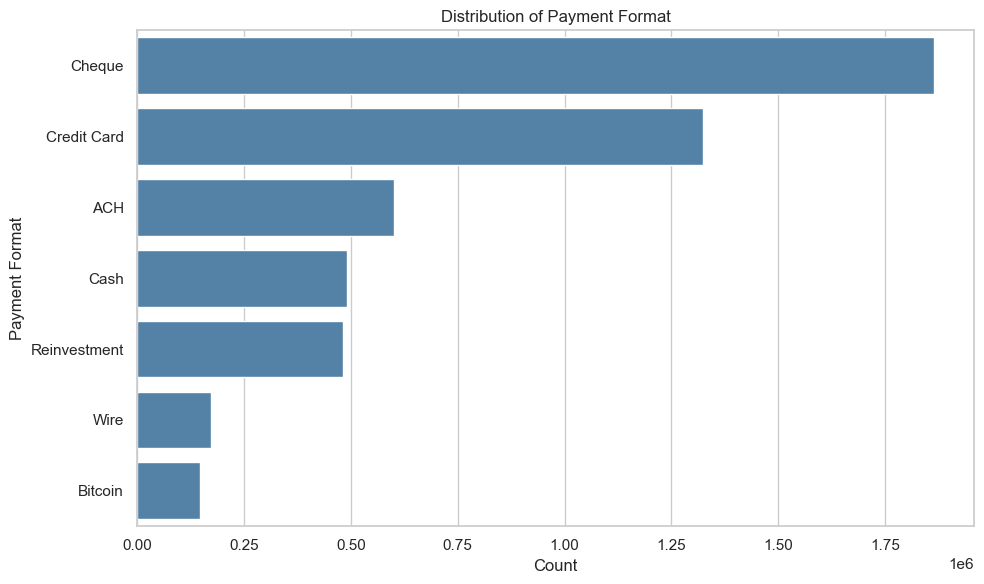

In [14]:

# Create output folder if needed
os.makedirs("outputs/plots", exist_ok=True)

# Count and sort payment formats
type_counts = df["payment_format"].value_counts().sort_values(ascending=False)

# Convert to DataFrame
type_df = type_counts.reset_index()
type_df.columns = ["payment_format", "count"]

# Plot with explicit order
plt.figure(figsize=(10, 6))
sns.barplot(
    data=type_df,
    x="count",
    y="payment_format",
    order=type_df["payment_format"],  # enforce descending order
    color="steelblue"
)

plt.title("Distribution of Payment Format")
plt.xlabel("Count")
plt.ylabel("Payment Format")
plt.tight_layout()

# Save to file
plt.savefig(os.path.join(OUTPUT_DIR, "payment_format_barchart.png"), dpi=300)

plt.show()


## 6. Correlations and Relationships
Compute and visualise correlations between numeric features to identify potential relationships and multicollinearity.

<Axes: >

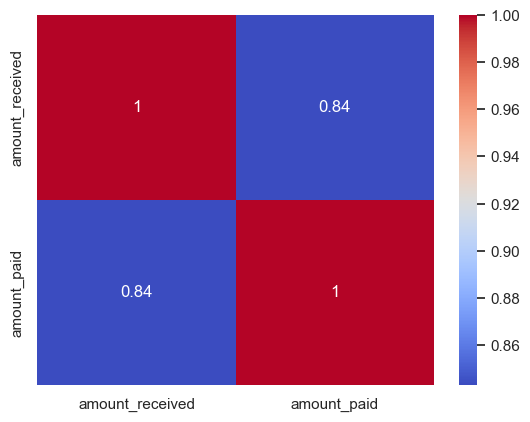

In [12]:
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [ ]:
# Summary statistics grouped by laundering status
summary_stats = (
    df.groupby('is_laundering')[['amount_received', 'amount_paid']]
    .describe()
    .transpose()
    .round(2)
)

display(summary_stats)

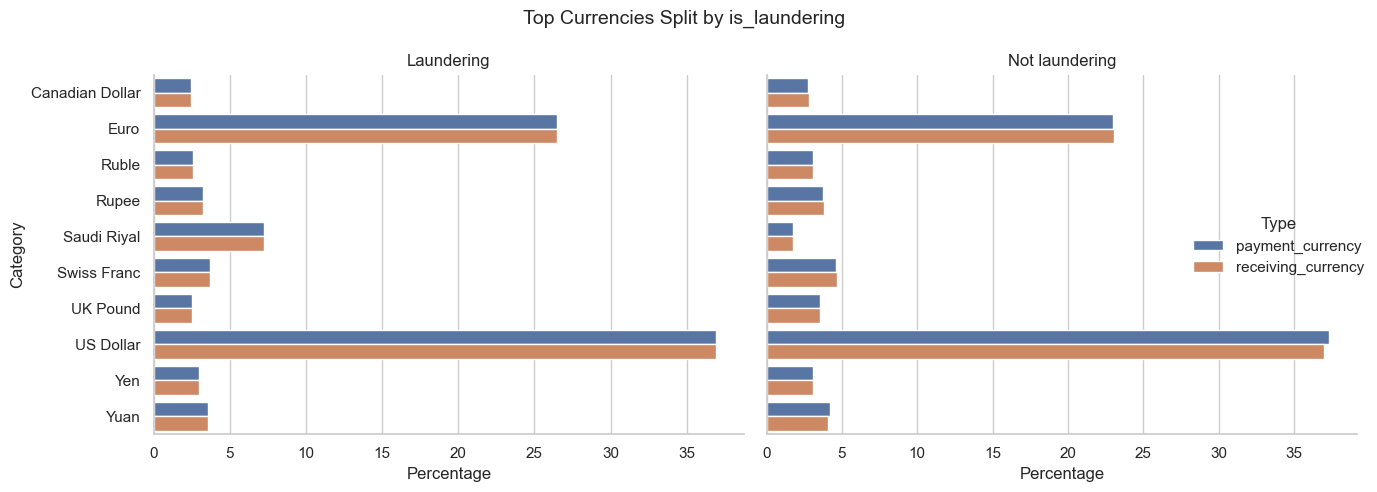

In [40]:
plot_normalized_grouped_bar_by_class(
    df,
    class_col='is_laundering',
    group_cols=('payment_currency', 'receiving_currency'),
    top_n=10,
    title_prefix="Top Currencies"
)

In [ ]:
# Top 30 Banks To and Top 30 Banks From for Laundering Subset

In [ ]:
# % of Payment Formats for Laundering Subset

## 7. Outlier Detection
Identify unusually large or small transactions that may indicate laundering or data entry errors.

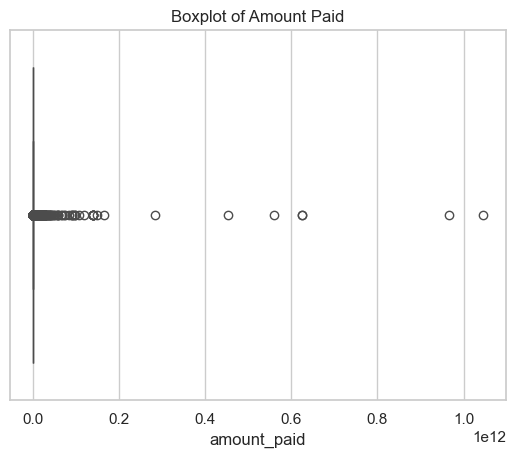

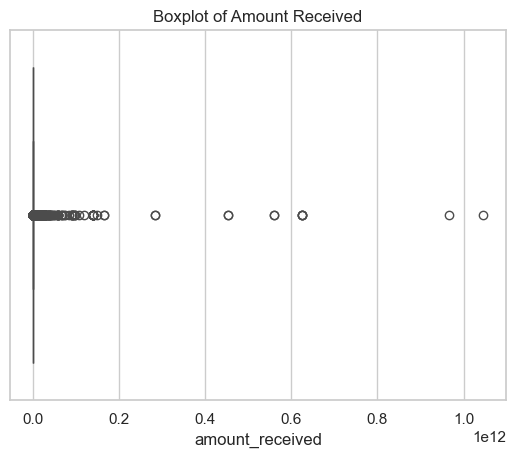

Outliers in Amount Paid: 881724


In [13]:
# Visualise amount distributions
sns.boxplot(x=df['amount_paid'])
plt.title("Boxplot of Amount Paid")
plt.show()

sns.boxplot(x=df['amount_received'])
plt.title("Boxplot of Amount Received")
plt.show()

# Flag outliers using IQR method
Q1 = df['amount_paid'].quantile(0.25)
Q3 = df['amount_paid'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['amount_paid'] < Q1 - 1.5 * IQR) | (df['amount_paid'] > Q3 + 1.5 * IQR)]
print(f"Outliers in Amount Paid: {len(outliers)}")

In [ ]:
# Check each one after log transformation

## 8. Feature Relationships and Dervied Columns
Examine relationships between related columns and create new features to capture discrepancies.

### Amount Paid vs Amount Received
Check whether these are always the same. If not, create a new column for the difference between the two for each transaction. 

In [34]:
# Create numeric laundering flag for aggregation
df["laundering_flag"] = df["is_laundering"].map({"Not laundering": 0, "Laundering": 1})

df['amount_difference'] = df['amount_paid'] - df['amount_received']
df['amount_mismatch'] = df['amount_difference'] != 0

print(f"Transactions with mismatched amounts: {df['amount_mismatch'].sum()}")

mismatch_count = df['amount_mismatch'].sum()
mismatch_pct = mismatch_count / len(df) * 100

print(f"Proportion of total transactions with mismatched amounts:  {mismatch_pct:.2f}%")

Transactions with mismatched amounts: 72158
Proportion of total transactions with mismatched amounts:  1.42%


### Receiving Currency vs Payment Currency
Check whether these are always the same. If not, create a new column that flags mismatches. 

In [35]:
# Create numeric laundering flag for aggregation
df["laundering_flag"] = df["is_laundering"].map({"Not laundering": 0, "Laundering": 1})
df['currency_mismatch'] = df['receiving_currency'] != df['payment_currency']

print(f"Transactions with currency mismatch: {df['currency_mismatch'].sum()}")

currency_mismatch_count = df['currency_mismatch'].sum()
currency_mismatch_pct = currency_mismatch_count / len(df) * 100

print(f"Transactions with currency mismatch:  {currency_mismatch_pct:.2f}%")

Transactions with currency mismatch: 72170
Transactions with currency mismatch:  1.42%


See if laundering is more common in cases with mismatches.

In [32]:
# Create numeric laundering flag for aggregation
df["laundering_flag"] = df["is_laundering"].map({"Not laundering": 0, "Laundering": 1}).astype(float)

df["amount_mismatch"] = df["amount_paid"] != df["amount_received"]
df["currency_mismatch"] = df["payment_currency"] != df["receiving_currency"]

# Amount mismatch vs laundering
mismatch_rate = df.groupby("amount_mismatch")["laundering_flag"].mean()
print("Laundering rate by amount_mismatch:\n", mismatch_rate)
# Currency mismatch vs laundering
currency_rate = df.groupby("currency_mismatch")["laundering_flag"].mean()
print("\nLaundering rate by currency_mismatch:\n", currency_rate)


Laundering rate by amount_mismatch:
 amount_mismatch
False   0.00
True    0.00
Name: laundering_flag, dtype: float64

Laundering rate by currency_mismatch:
 currency_mismatch
False   0.00
True    0.00
Name: laundering_flag, dtype: float64

Laundering rate by any mismatch:
 any_mismatch
False   0.00
True    0.00
Name: laundering_flag, dtype: float64


In [64]:
# Total laundering transactions with amount mismatch
amount_mismatch_counts = df[df["laundering_flag"] == 1]["amount_mismatch"].value_counts()
print("Flagged transactions by amount_mismatch:\n", amount_mismatch_counts)

# Total laundering transactions with currency mismatch
currency_mismatch_counts = df[df["laundering_flag"] == 1]["currency_mismatch"].value_counts()
print("\nFlagged transactions by currency_mismatch:\n", currency_mismatch_counts)

# Not useful as a predictive feature

Flagged transactions by amount_mismatch:
 amount_mismatch
False    5177
Name: count, dtype: int64

Flagged transactions by currency_mismatch:
 currency_mismatch
False    5177
Name: count, dtype: int64


## 9. Time Series Analysis
Analyse transaction volume and laundering activity over time to identify patterns, spikes or anomalies.

In [36]:
# Convert timestamp to datetime and extract features
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

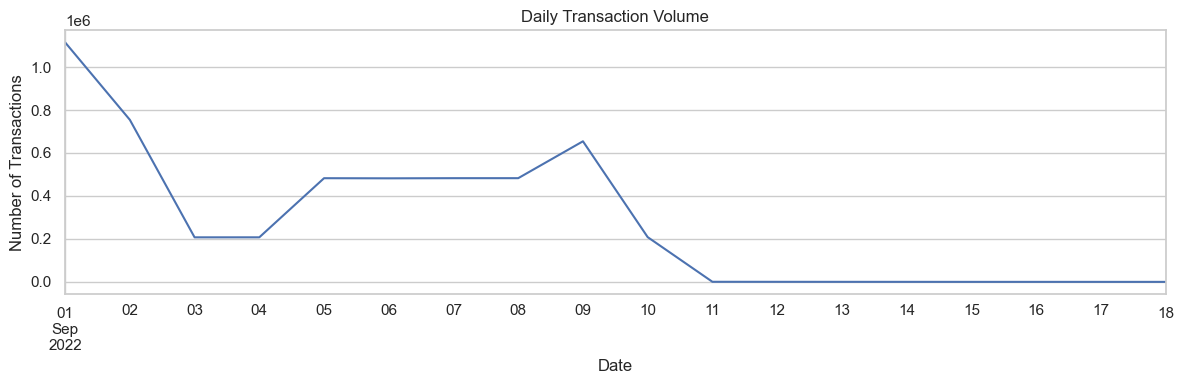

In [39]:
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Daily transaction volume
daily_counts = df.groupby(df["timestamp"].dt.date).size()

# Convert index to datetime for plotting
daily_counts.index = pd.to_datetime(daily_counts.index)

# Get min and max dates
start = daily_counts.index.min()
end = daily_counts.index.max()

# Plot
daily_counts.plot(figsize=(12, 4), title="Daily Transaction Volume")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xlim(start, end)  
plt.tight_layout()
plt.show()

C:\Users\marga\AppData\Local\Temp\ipykernel_7192\454885572.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  laundering_trend = df.groupby([df['timestamp'].dt.date, 'is_laundering']).size().unstack(fill_value=0)


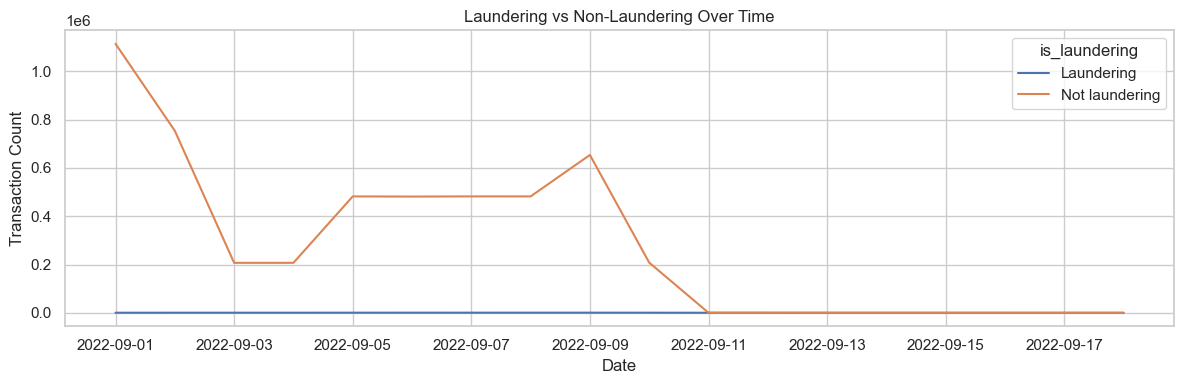

In [40]:
# Laundering vs. non-laundering over time
laundering_trend = df.groupby([df['timestamp'].dt.date, 'is_laundering']).size().unstack(fill_value=0)

laundering_trend.plot(kind='line', figsize=(12, 4), title="Laundering vs Non-Laundering Over Time")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(OUTPUT_DIR, "laundering_vs_non_laundering.png"), dpi=300)



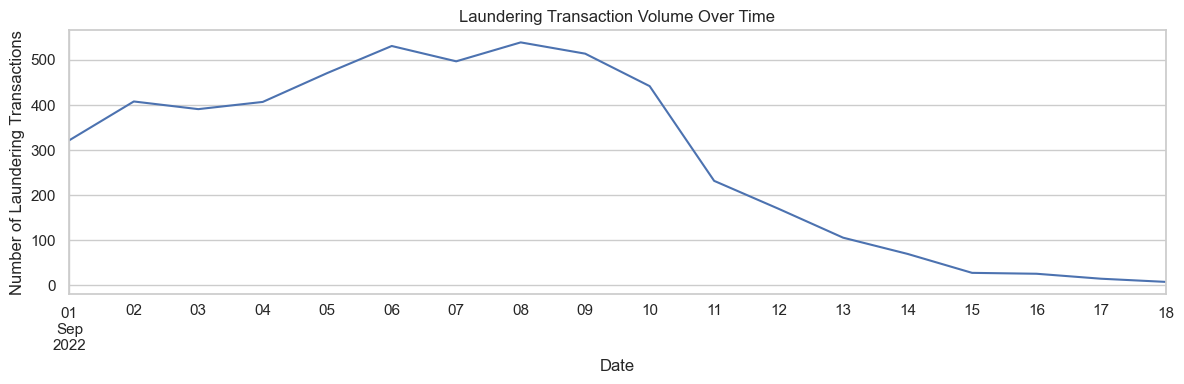

In [44]:
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter for laundering cases only
laundering_only = df[df["is_laundering"] == "Laundering"]

# Group by date
laundering_counts = laundering_only.groupby(laundering_only["timestamp"].dt.date).size()

# Convert index to datetime for plotting
laundering_counts.index = pd.to_datetime(laundering_counts.index)

# Plot
laundering_counts.plot(kind="line", figsize=(12, 4), title="Laundering Transaction Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Laundering Transactions")
plt.xlim(laundering_counts.index.min(), laundering_counts.index.max())  # Optional: enforce full range
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(OUTPUT_DIR, "laundering_only_volume.png"), dpi=300)


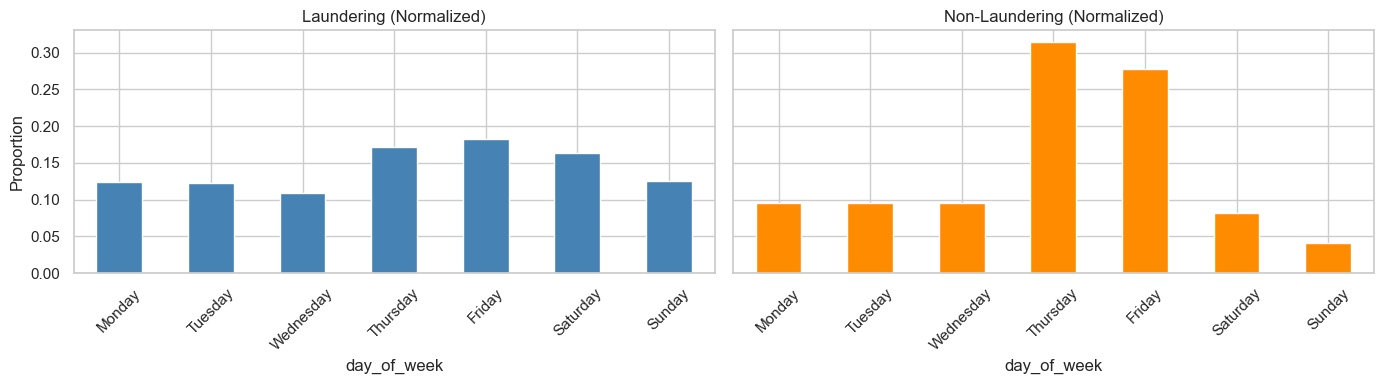

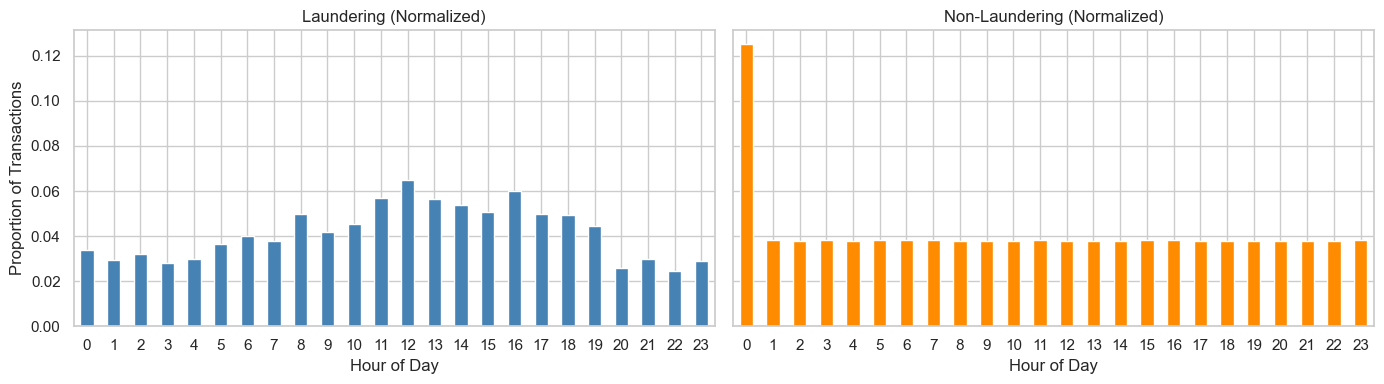

In [51]:
# Normalize laundering
laundering_day = laundering_df["day_of_week"].value_counts(normalize=True).reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Normalize non-laundering
non_laundering_day = non_laundering_df["day_of_week"].value_counts(normalize=True).reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
laundering_day.plot(kind="bar", ax=axes[0], color="steelblue", title="Laundering (Normalized)")
non_laundering_day.plot(kind="bar", ax=axes[1], color="darkorange", title="Non-Laundering (Normalized)")
for ax in axes: ax.set_ylabel("Proportion"); ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "normalized_day_of_week_comparison.png"), dpi=300)
plt.show()

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour

# Split datasets
laundering_df = df[df["is_laundering"] == "Laundering"]
non_laundering_df = df[df["is_laundering"] == "Not laundering"]

# Normalize counts
laundering_hour = laundering_df["hour"].value_counts(normalize=True).sort_index()
non_laundering_hour = non_laundering_df["hour"].value_counts(normalize=True).sort_index()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

laundering_hour.plot(kind="bar", ax=axes[0], color="steelblue", title="Laundering (Normalized)")
non_laundering_hour.plot(kind="bar", ax=axes[1], color="darkorange", title="Non-Laundering (Normalized)")

for ax in axes:
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Proportion of Transactions")
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels(range(0, 24), rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "normalized_hour_comparison.png"), dpi=300)
plt.show()

### Explore whether laundering is more likely to happen during off-peak hours or weekends

In [53]:
# Create numeric laundering flag for aggregation
df["laundering_flag"] = df["is_laundering"].map({"Not laundering": 0, "Laundering": 1}).astype(float)


# Define off-hours
df['off_hours'] = (df['hour'] < 8) | (df['hour'] > 18)

# Compare laundering rates
off_hour_rate = df.groupby('off_hours')['laundering_flag'].mean()
print("Laundering rate by off-hours:\n", off_hour_rate)


Laundering rate by off-hours:
 off_hours
False   0.00
True    0.00
Name: laundering_flag, dtype: float64


In [63]:
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour

# Define off-hours
df["off_hours"] = (df["hour"] < 8) | (df["hour"] > 18)

# Filter laundering transactions
laundering_df = df[df["laundering_flag"] == 1]

# Count laundering transactions by off-hours
print(laundering_df["off_hours"].value_counts())

off_hours
False    2997
True     2180
Name: count, dtype: int64


In [56]:
# Define weekend
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

# Compare laundering rates
weekend_rate = df.groupby('is_weekend')['laundering_flag'].mean()
print("\nLaundering rate by weekend:\n", weekend_rate)



Laundering rate by weekend:
 is_weekend
False   0.00
True    0.00
Name: laundering_flag, dtype: float64


In [61]:
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filter laundering transactions
laundering_timestamps = df[df["laundering_flag"] == 1]["timestamp"]

# Check if each timestamp is on a weekend
is_weekend = laundering_timestamps.dt.day_name().isin(["Saturday", "Sunday"])

# Count weekend vs weekday laundering transactions
print(is_weekend.value_counts())


timestamp
False    3682
True     1495
Name: count, dtype: int64


In [72]:
df['same_bank'] = df['from_bank'].astype(str) == df['to_bank'].astype(str)
laundering_df = df[df['laundering_flag'] == 1]
same_bank = laundering_df['same_bank'].value_counts().sort_index()
print(same_bank)

same_bank
False    5074
True      103
Name: count, dtype: int64


In [67]:
# Filter laundering transactions
laundering_df = df[df["laundering_flag"] == 1]

# Count sender frequency
sender_freq_counts = laundering_df["sender_freq"].value_counts().sort_index()
print("Sender frequency distribution for laundering transactions:\n", sender_freq_counts)

# Count receiver frequency
receiver_freq_counts = laundering_df["receiver_freq"].value_counts().sort_index()
print("\nReceiver frequency distribution for laundering transactions:\n", receiver_freq_counts)

Sender frequency distribution for laundering transactions:
 sender_freq
1         122
2         496
3         681
4         478
5         202
         ... 
17264      21
18663      21
20497      29
103018    158
168672    243
Name: count, Length: 178, dtype: int64

Receiver frequency distribution for laundering transactions:
 receiver_freq
1       49
2      208
3      369
4      284
5      246
      ... 
82      13
83       1
84       1
93       1
159      1
Name: count, Length: 76, dtype: int64


In [68]:
print("Sender freq stats:\n", laundering_df["sender_freq"].describe())
print("\nReceiver freq stats:\n", laundering_df["receiver_freq"].describe())

Sender freq stats:
 count     5177.00
mean     11741.02
std      39142.19
min          1.00
25%          3.00
50%         16.00
75%         45.00
max     168672.00
Name: sender_freq, dtype: float64

Receiver freq stats:
 count   5177.00
mean      21.03
std       16.08
min        1.00
25%        6.00
50%       19.00
75%       30.00
max      159.00
Name: receiver_freq, dtype: float64


## Initial Findings

- Most transactions are non-laundering.
- Certain banks and currencies appear more frequently in the transactions, but not sure if this will help identify money-laundering patterns. 
- Transactions with currency and amount mismatches had no positive flags so this will not help train the model.
- There seems to be potential to investigate time and date derived features. 
- More complex interactions between features may need to be investigated in future analysis. 

In [ ]:
!python ../src/auto_report.py